# Import the dependencies

In [1]:
import re
import random
import numpy as np
import pandas as pd

from tqdm import tqdm
from collections import Counter

import tensorflow as tf
import tensorflow_addons as tfa
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM, Conv1D, GlobalAveragePooling1D
from keras.callbacks import ModelCheckpoint

import tensorflow as tf
from transformers import BertConfig
from transformers import RobertaTokenizerFast

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score

from matplotlib import pyplot as plt
from matplotlib import rcParams

import sys
import time

sys.path.append("../../../")
from calculus_path_mod.terms.pseudonym import *
from calculus_path_mod.reduction_strategy import *
from calculus_path_mod.terms.arithm_complex_ops import *

C:\Users\voldo\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:177: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\Users\voldo\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\voldo\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Py

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Available GPUs:", physical_devices)

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [1]:
sequence_len = 512
batch_size = 64

config = BertConfig(
    vocab_size=9,
    hidden_size=84,
    num_hidden_layers=2,
    num_attention_heads=6,
    intermediate_size=64,
    max_position_embeddings=sequence_len,
    num_labels=2
)

epochs = 30

NameError: name 'BertConfig' is not defined

# Load & Prepare the data

In [4]:
all_data = pd.read_csv("../../article_models_reduct_steps_by_simple_str/data_steps/steps_simple_term_str.csv", delimiter=',')

# leave only unique terms
print(f"Count all terms: {len(all_data)}\n")
all_data = all_data.drop_duplicates(subset="simple_terms").reset_index(drop=True)
print(f"Count original terms: {len(all_data)}\n")

# shuffle the dataset
all_data = shuffle(all_data, random_state=33).reset_index(drop=True)
all_data = all_data.drop_duplicates(["simple_terms"])

# drop unreducable by LO or RI
print(f"number samples: {len(all_data)}")
all_data = all_data[[x_ != 1000 for x_ in all_data["RI_steps_num"]]].reset_index(drop=True)
all_data = all_data[[x_ != 1000 for x_ in all_data["LO_steps_num"]]].reset_index(drop=True)
print(f"number samples only reducable: {len(all_data)}\n")

print(f"max RI steps count: {max(all_data['RI_steps_num'])}")
print(f"max LO steps count: {max(all_data['LO_steps_num'])}")

x_test = all_data["simple_terms"].tolist()
# RI has fewer steps -> 1
# Otherwise 0
y_test = [1 if los > ris else 0 for los, ris in zip(all_data["LO_steps_num"].tolist(), all_data["RI_steps_num"].tolist())]

print(f"Count TESTING samples: {len(y_test)}")

Count all terms: 4251

Count original terms: 4251

number samples: 4251
number samples only reducable: 4220

max RI steps count: 386
max LO steps count: 219
Count TESTING samples: 4220


In [5]:
all_data = pd.read_csv("../../article_models_reduct_steps_by_simple_str/data_steps/steps_simple_term_str_extended.csv", delimiter=',')

# leave only unique terms
print(f"Count all terms: {len(all_data)}\n")
all_data = all_data.drop_duplicates(subset="simple_terms").reset_index(drop=True)
print(f"Count original terms: {len(all_data)}\n")

# shuffle the dataset
all_data = shuffle(all_data, random_state=33).reset_index(drop=True)
all_data = all_data.drop_duplicates(["simple_terms"])

# drop unreducable by LO or RI
print(f"number samples: {len(all_data)}")
all_data = all_data[[x_ != 1000 for x_ in all_data["RI_steps_num"]]].reset_index(drop=True)
all_data = all_data[[x_ != 1000 for x_ in all_data["LO_steps_num"]]].reset_index(drop=True)
print(f"number samples only reducable: {len(all_data)}\n")

print(f"max RI steps count: {max(all_data['RI_steps_num'])}")
print(f"max LO steps count: {max(all_data['LO_steps_num'])}")

x_train = all_data["simple_terms"].tolist()
# RI has fewer steps -> 1
# Otherwise 0
y_train = [1 if los > ris else 0 for los, ris in zip(all_data["LO_steps_num"].tolist(), all_data["RI_steps_num"].tolist())]

print(f"Count TRAINING samples: {len(y_train)}")

Count all terms: 44568

Count original terms: 44568

number samples: 44568
number samples only reducable: 42469

max RI steps count: 400
max LO steps count: 308
Count TRAINING samples: 42469


In [6]:
tokenizer = RobertaTokenizerFast.from_pretrained("../../transformers_to_lo_steps_prediciton/fine_models", max_len=sequence_len)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
x_train = [x_.replace("@x.", "y").replace(" ", "") for x_ in x_train]
x_test = [x_.replace("@x.", "y").replace(" ", "") for x_ in x_test]

train_df = pd.DataFrame({"term_str": x_train, "is_ri_best": y_train})
test_df = pd.DataFrame({"term_str": x_test, "is_ri_best": y_test})

def preprocess(example):
    # Tokenize the prompt
    tokenized_texts = tokenizer(example['term_str'].to_list(), truncation=True, padding='max_length', max_length=sequence_len, return_tensors="tf")
    labels = tf.convert_to_tensor(example["is_ri_best"])
    return tokenized_texts, labels


tokenized_train_data = preprocess(train_df)
tokenized_test_data = preprocess(test_df)

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices((dict(tokenized_train_data[0]), tokenized_train_data[1])).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(tokenized_test_data[0]), tokenized_test_data[1])).batch(batch_size)

# Define the model

In [9]:
from transformers import TFBertModel
from keras.layers import Dense, Input, Flatten, AveragePooling1D, Dropout
from keras.models import Model

bert = TFBertModel(config=config)
bert.build()

input_ids_in = Input(shape=(sequence_len,), name='input_ids', dtype='int32')
input_masks_in = Input(shape=(sequence_len,), name='attention_mask', dtype='int32')

embedding_layer = bert(input_ids_in, attention_mask=input_masks_in)[0]
outputs = AveragePooling1D(pool_size=50)(embedding_layer)
outputs = Flatten()(outputs)
outputs = Dropout(rate=0.1)(outputs)
outputs = Dense(units=1, activation="sigmoid")(outputs)
model = Model(inputs=[input_ids_in, input_masks_in], outputs=outputs)

In [10]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tfa.metrics.F1Score(num_classes=1, threshold=0.5)])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  130832      ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

In [11]:
# model_structure = model.to_json()
# with open("./fine_models/model_ri.json", 'w') as json_file:
#     json_file.write(model_structure)

In [12]:
# Define the ModelCheckpoint callback
f1_callback = ModelCheckpoint(
    filepath='./fine_models/model_ri_best_f1_only_reducable.h5',  # Specify the path to save the best model
    monitor='val_f1_score',  # Metric to monitor (e.g., validation loss)
    save_best_only=True,  # Save only the best model
    mode='max',  # 'min' or 'max' depending on the monitored metric
    verbose=0  # Print a message when saving the model
)

step_callback = ModelCheckpoint('./fine_models/model_ri_only_reducable.h5', save_weights_only=True, save_freq=1)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="ri_best_logs/id_1", histogram_freq=1)

In [13]:
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs, verbose=1, callbacks=[f1_callback, step_callback, tensorboard_callback])

Epoch 1/30
664/664 [==============================] - 175s 255ms/step - loss: 0.3533 - accuracy: 0.8758 - precision: 0.3902 - recall: 0.0184 - f1_score: 0.0351 - val_loss: 0.2838 - val_accuracy: 0.9100 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 2/30
664/664 [==============================] - 172s 260ms/step - loss: 0.3336 - accuracy: 0.8789 - precision: 0.6179 - recall: 0.0397 - f1_score: 0.0745 - val_loss: 0.2685 - val_accuracy: 0.9104 - val_precision: 0.6667 - val_recall: 0.0053 - val_f1_score: 0.0105
Epoch 3/30
664/664 [==============================] - 163s 246ms/step - loss: 0.3269 - accuracy: 0.8809 - precision: 0.6810 - recall: 0.0577 - f1_score: 0.1063 - val_loss: 0.2702 - val_accuracy: 0.9102 - val_precision: 0.5000 - val_recall: 0.0026 - val_f1_score: 0.0052
Epoch 4/30
664/664 [==============================] - 160s 241ms/step - loss: 0.3231 - accuracy: 0.8826 - precision: 0.7308 - recall: 0.0713 - f1_score: 0.1299 - val_loss: 0.2677

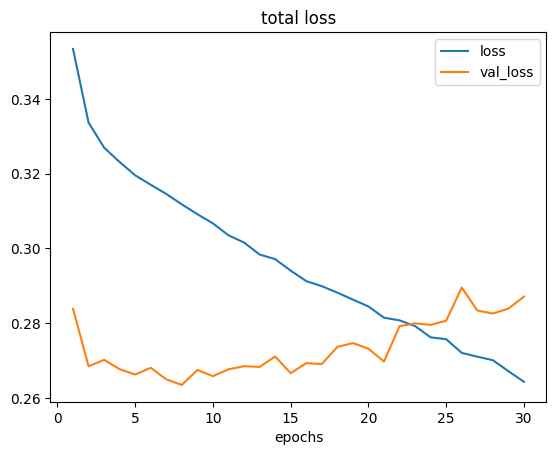

In [14]:
plt.plot(range(1, epochs + 1), history.history['loss'], label="loss")
plt.plot(range(1, epochs + 1), history.history['val_loss'], label="val_loss")
plt.xlabel("epochs")
plt.title("total loss")
plt.legend()
plt.show()

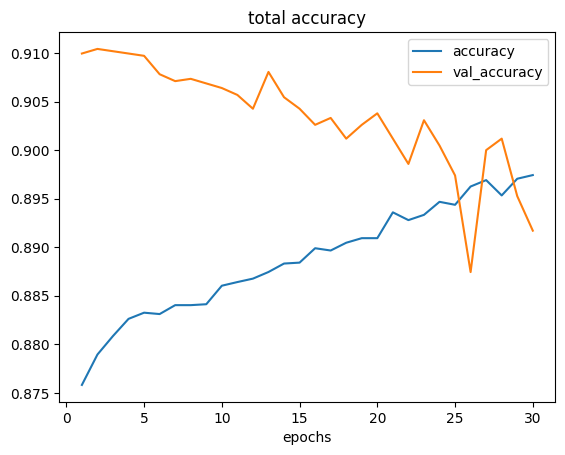

In [15]:
plt.plot(range(1, epochs + 1), history.history['accuracy'], label="accuracy")
plt.plot(range(1, epochs + 1), history.history['val_accuracy'], label="val_accuracy")
plt.xlabel("epochs")
plt.title("total accuracy")

plt.legend()
plt.show()

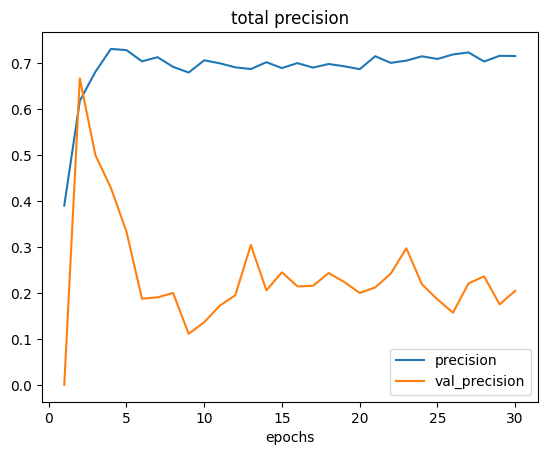

In [16]:
plt.plot(range(1, epochs + 1), history.history['precision'], label="precision")
plt.plot(range(1, epochs + 1), history.history['val_precision'], label="val_precision")
plt.xlabel("epochs")
plt.title("total precision")

plt.legend()
plt.show()

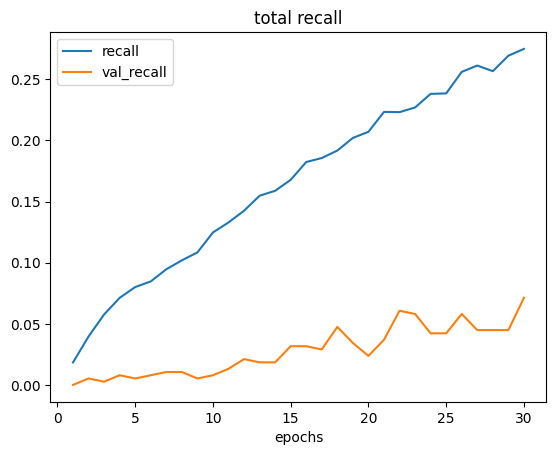

In [17]:
plt.plot(range(1, epochs + 1), history.history['recall'], label="recall")
plt.plot(range(1, epochs + 1), history.history['val_recall'], label="val_recall")
plt.xlabel("epochs")
plt.title("total recall")

plt.legend()
plt.show()

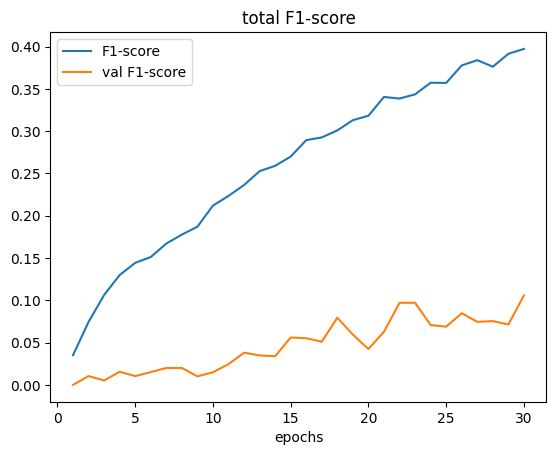

In [18]:
plt.plot(range(1, epochs + 1), history.history['f1_score'], label="F1-score")
plt.plot(range(1, epochs + 1), history.history['val_f1_score'], label="val F1-score")
plt.xlabel("epochs")
plt.title("total F1-score")

plt.legend()
plt.show()

Epoch 1/30
664/664 [==============================] - 183s 275ms/step - loss: 0.2641 - accuracy: 0.8979 - precision: 0.7110 - recall: 0.2860 - f1_score: 0.4079 - val_loss: 0.2872 - val_accuracy: 0.8924 - val_precision: 0.2222 - val_recall: 0.0792 - val_f1_score: 0.1167
Epoch 2/30
664/664 [==============================] - 192s 289ms/step - loss: 0.2620 - accuracy: 0.8981 - precision: 0.7150 - recall: 0.2845 - f1_score: 0.4070 - val_loss: 0.2936 - val_accuracy: 0.8936 - val_precision: 0.2308 - val_recall: 0.0792 - val_f1_score: 0.1179
Epoch 3/30
664/664 [==============================] - 183s 276ms/step - loss: 0.2590 - accuracy: 0.8995 - precision: 0.7203 - recall: 0.2985 - f1_score: 0.4221 - val_loss: 0.2925 - val_accuracy: 0.8927 - val_precision: 0.2431 - val_recall: 0.0923 - val_f1_score: 0.1338
Epoch 4/30
664/664 [==============================] - 187s 281ms/step - loss: 0.2572 - accuracy: 0.8996 - precision: 0.7189 - recall: 0.3008 - f1_score: 0.4241 - val_loss: 0.2898 - val_accur

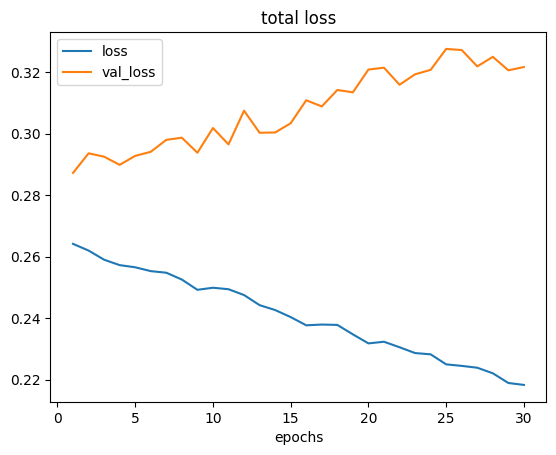

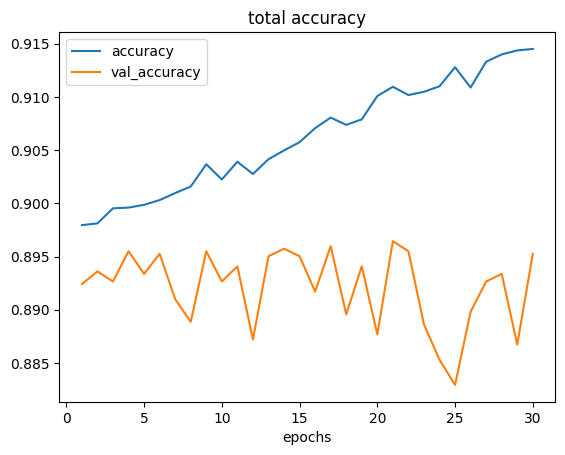

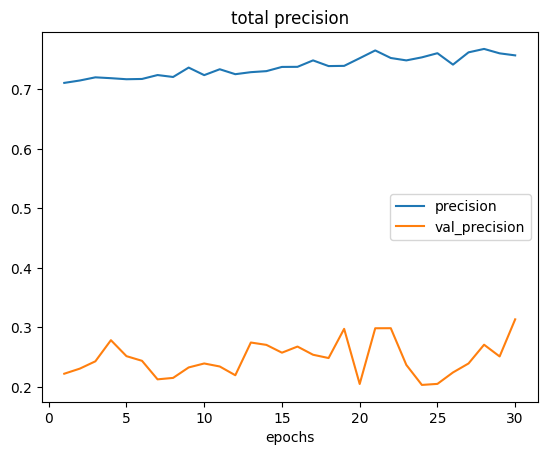

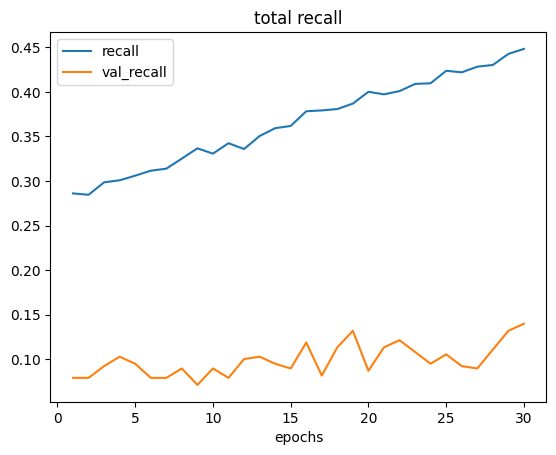

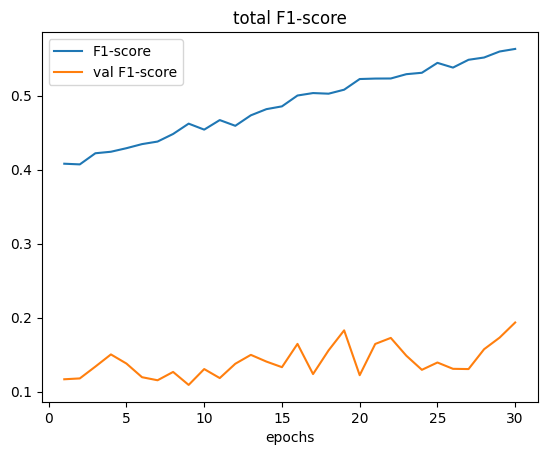

In [19]:
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs, verbose=1,
                    callbacks=[f1_callback, step_callback, tensorboard_callback])
plt.plot(range(1, epochs + 1), history.history['loss'], label="loss")
plt.plot(range(1, epochs + 1), history.history['val_loss'], label="val_loss")
plt.xlabel("epochs")
plt.title("total loss")
plt.legend()

plt.show()
plt.plot(range(1, epochs + 1), history.history['accuracy'], label="accuracy")
plt.plot(range(1, epochs + 1), history.history['val_accuracy'], label="val_accuracy")
plt.xlabel("epochs")
plt.title("total accuracy")

plt.legend()
plt.show()
plt.plot(range(1, epochs + 1), history.history['precision'], label="precision")
plt.plot(range(1, epochs + 1), history.history['val_precision'], label="val_precision")
plt.xlabel("epochs")
plt.title("total precision")

plt.legend()
plt.show()
plt.plot(range(1, epochs + 1), history.history['recall'], label="recall")
plt.plot(range(1, epochs + 1), history.history['val_recall'], label="val_recall")
plt.xlabel("epochs")
plt.title("total recall")

plt.legend()
plt.show()
plt.plot(range(1, epochs + 1), history.history['f1_score'], label="F1-score")
plt.plot(range(1, epochs + 1), history.history['val_f1_score'], label="val F1-score")
plt.xlabel("epochs")
plt.title("total F1-score")

plt.legend()
plt.show()

In [20]:
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs, verbose=1,
                    callbacks=[f1_callback, step_callback, tensorboard_callback])

Epoch 1/30
664/664 [==============================] - 156s 234ms/step - loss: 0.2162 - accuracy: 0.9154 - precision: 0.7612 - recall: 0.4542 - f1_score: 0.5689 - val_loss: 0.3298 - val_accuracy: 0.8886 - val_precision: 0.2618 - val_recall: 0.1319 - val_f1_score: 0.1754
Epoch 2/30
664/664 [==============================] - 165s 249ms/step - loss: 0.2178 - accuracy: 0.9144 - precision: 0.7593 - recall: 0.4441 - f1_score: 0.5604 - val_loss: 0.3284 - val_accuracy: 0.8943 - val_precision: 0.2781 - val_recall: 0.1108 - val_f1_score: 0.1585
Epoch 3/30
664/664 [==============================] - 161s 242ms/step - loss: 0.2150 - accuracy: 0.9151 - precision: 0.7579 - recall: 0.4546 - f1_score: 0.5683 - val_loss: 0.3386 - val_accuracy: 0.8855 - val_precision: 0.2234 - val_recall: 0.1108 - val_f1_score: 0.1481
Epoch 4/30
664/664 [==============================] - 164s 247ms/step - loss: 0.2129 - accuracy: 0.9164 - precision: 0.7653 - recall: 0.4611 - f1_score: 0.5755 - val_loss: 0.3408 - val_accur

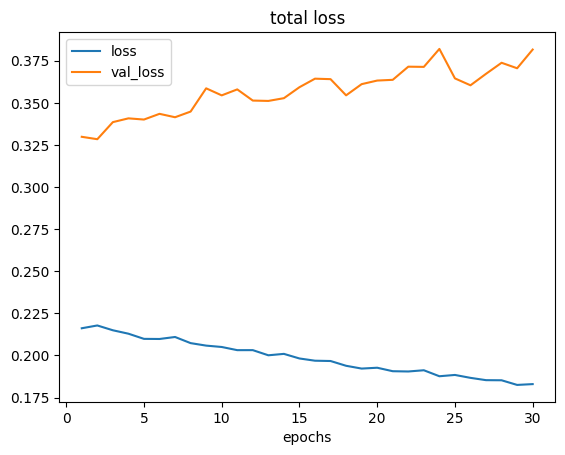

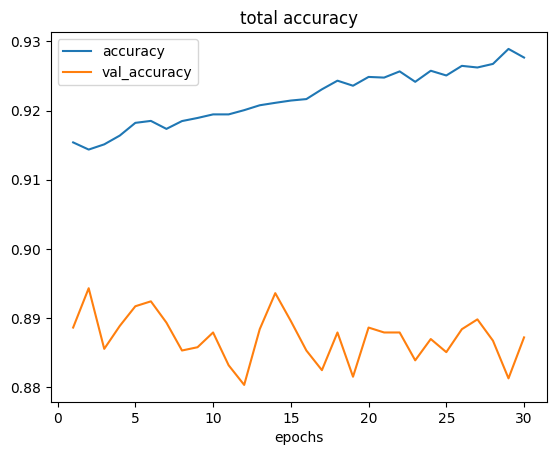

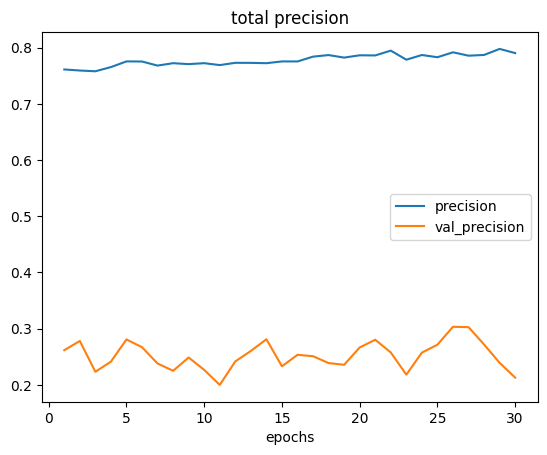

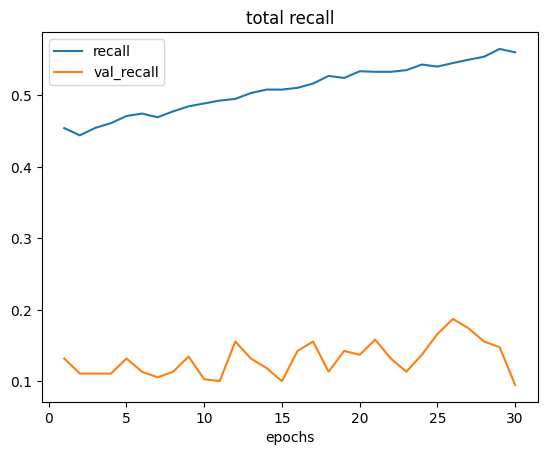

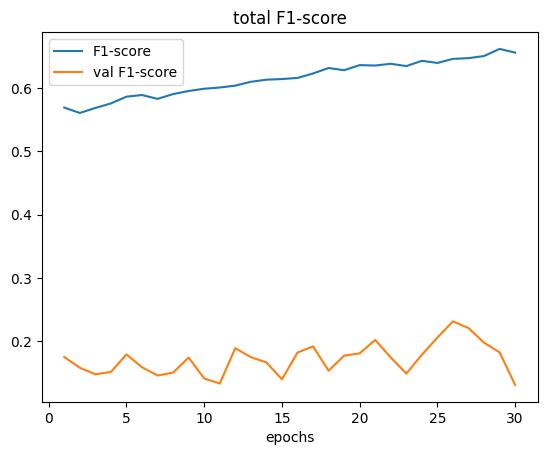

In [21]:
plt.plot(range(1, epochs + 1), history.history['loss'], label="loss")
plt.plot(range(1, epochs + 1), history.history['val_loss'], label="val_loss")
plt.xlabel("epochs")
plt.title("total loss")
plt.legend()

plt.show()
plt.plot(range(1, epochs + 1), history.history['accuracy'], label="accuracy")
plt.plot(range(1, epochs + 1), history.history['val_accuracy'], label="val_accuracy")
plt.xlabel("epochs")
plt.title("total accuracy")

plt.legend()
plt.show()
plt.plot(range(1, epochs + 1), history.history['precision'], label="precision")
plt.plot(range(1, epochs + 1), history.history['val_precision'], label="val_precision")
plt.xlabel("epochs")
plt.title("total precision")

plt.legend()
plt.show()
plt.plot(range(1, epochs + 1), history.history['recall'], label="recall")
plt.plot(range(1, epochs + 1), history.history['val_recall'], label="val_recall")
plt.xlabel("epochs")
plt.title("total recall")

plt.legend()
plt.show()
plt.plot(range(1, epochs + 1), history.history['f1_score'], label="F1-score")
plt.plot(range(1, epochs + 1), history.history['val_f1_score'], label="val F1-score")
plt.xlabel("epochs")
plt.title("total F1-score")

plt.legend()
plt.show()

In [22]:
def calculate_accuracy(actual_labels, predicted_labels):
    correct_predictions = sum(1 for actual, predicted in zip(actual_labels, predicted_labels) if actual == predicted)
    total_predictions = len(actual_labels)
    accuracy = correct_predictions / total_predictions
    return accuracy


from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes, class_labels, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function plots the confusion matrix of a classification model.

    Args:
        y_true (numpy.ndarray): The ground truth labels.
        y_pred (numpy.ndarray): The predicted labels.
        classes (list): The list of class labels.
        class_labels: The list of class names.
        normalize (bool, optional): Whether to normalize the confusion matrix. Defaults to False.
        title (str, optional): The title of the plot. Defaults to None.
        cmap (matplotlib.colors.Colormap, optional): The colormap to use for the plot. Defaults to plt.cm.Blues.
    """

    cm = confusion_matrix(y_true, y_pred, labels=classes)

    if normalize:
        cm = confusion_matrix(y_true, y_pred, labels=classes).astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(class_labels)
    ax.set_yticklabels(class_labels)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_title(title)
    fig.colorbar(im)

    thresh = cm.max() / 2.
    for i in range(len(classes)):
        for j in range(len(classes)):
            ij = float(cm[i, j])
            ax.text(j, i, f"{ij:.2f}", ha='center', va='center', color='white' if ij > thresh else 'black')

    plt.tight_layout()
    plt.show()

# TRAINED MODEL (after 90 epochs)

In [23]:
y_test_pred = model.predict(test_dataset)
y_train_pred = model.predict(train_dataset)

y_test_nums = y_test
y_train_nums = y_train

664/664 [==============================] - 48s 72ms/step


Test accuracy: 0.8291469194312796


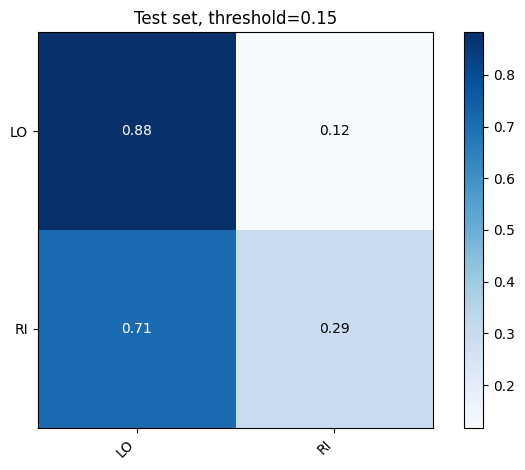

Train accuracy: 0.9255221455650003


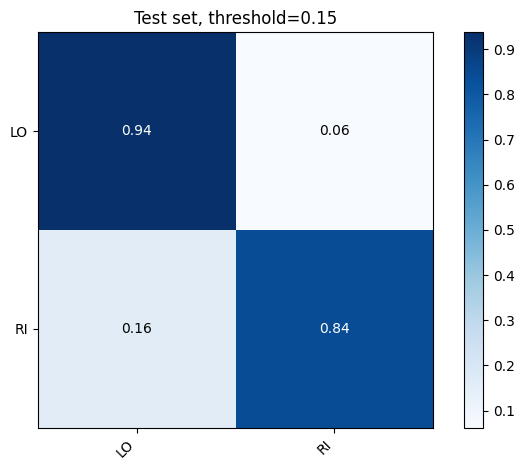

In [24]:
THRESHOLD = 0.15

y_test_pred_nums = [0 if x_ < THRESHOLD else 1 for x_ in y_test_pred]
y_train_pred_nums = [0 if x_ < THRESHOLD else 1 for x_ in y_train_pred]

print("Test accuracy:", calculate_accuracy(y_test_nums, y_test_pred_nums))
plot_confusion_matrix(y_test_nums, y_test_pred_nums, classes=[0, 1], class_labels=["LO", "RI"], normalize=True, title=f"Test set, threshold={THRESHOLD}")

print("Train accuracy:", calculate_accuracy(y_train_nums, y_train_pred_nums))
plot_confusion_matrix(y_train_nums, y_train_pred_nums, classes=[0, 1], class_labels=["LO", "RI"], normalize=True, title=f"Test set, threshold={THRESHOLD}")

Test accuracy: 0.859478672985782


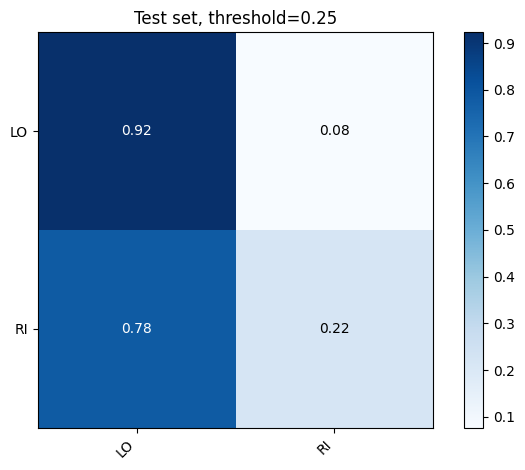

Train accuracy: 0.9420518495844027


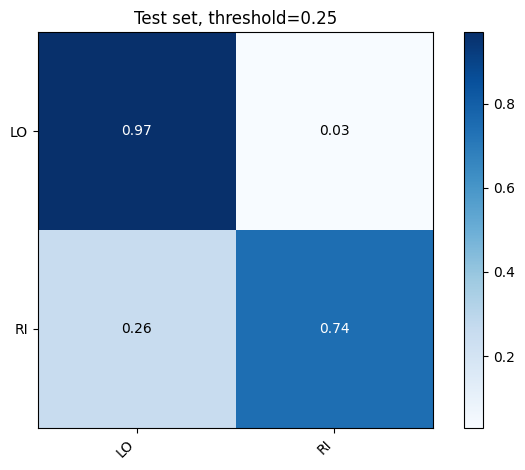

In [25]:
THRESHOLD = 0.25

y_test_pred_nums = [0 if x_ < THRESHOLD else 1 for x_ in y_test_pred]
y_train_pred_nums = [0 if x_ < THRESHOLD else 1 for x_ in y_train_pred]

print("Test accuracy:", calculate_accuracy(y_test_nums, y_test_pred_nums))
plot_confusion_matrix(y_test_nums, y_test_pred_nums, classes=[0, 1], class_labels=["LO", "RI"], normalize=True, title=f"Test set, threshold={THRESHOLD}")

print("Train accuracy:", calculate_accuracy(y_train_nums, y_train_pred_nums))
plot_confusion_matrix(y_train_nums, y_train_pred_nums, classes=[0, 1], class_labels=["LO", "RI"], normalize=True, title=f"Test set, threshold={THRESHOLD}")

Test accuracy: 0.8739336492890996


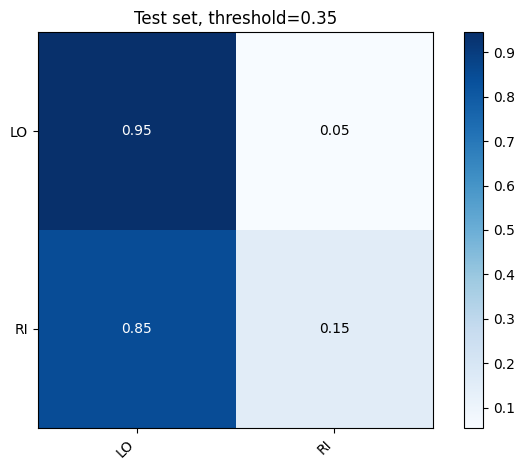

Train accuracy: 0.9438178436035697


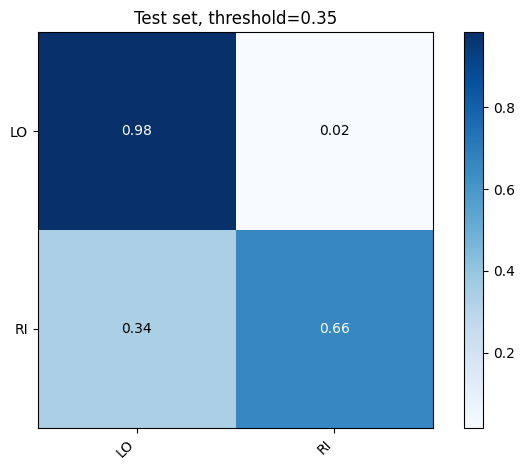

In [26]:
THRESHOLD = 0.35

y_test_pred_nums = [0 if x_ < THRESHOLD else 1 for x_ in y_test_pred]
y_train_pred_nums = [0 if x_ < THRESHOLD else 1 for x_ in y_train_pred]

print("Test accuracy:", calculate_accuracy(y_test_nums, y_test_pred_nums))
plot_confusion_matrix(y_test_nums, y_test_pred_nums, classes=[0, 1], class_labels=["LO", "RI"], normalize=True, title=f"Test set, threshold={THRESHOLD}")

print("Train accuracy:", calculate_accuracy(y_train_nums, y_train_pred_nums))
plot_confusion_matrix(y_train_nums, y_train_pred_nums, classes=[0, 1], class_labels=["LO", "RI"], normalize=True, title=f"Test set, threshold={THRESHOLD}")

Test accuracy: 0.8872037914691943


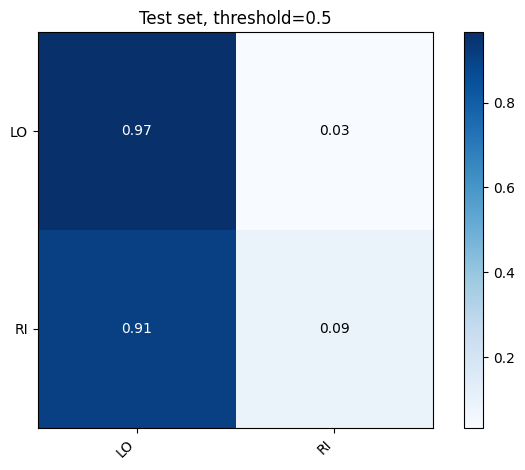

Train accuracy: 0.9383550354376133


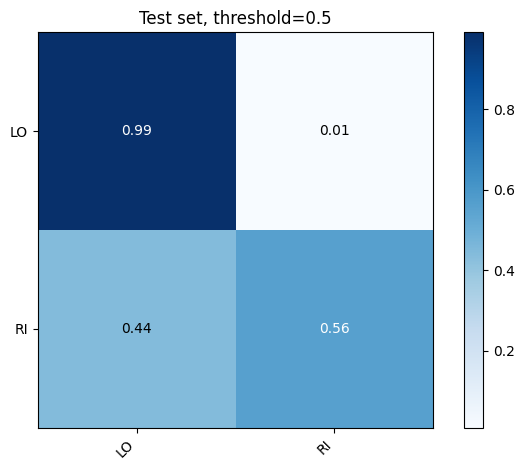

In [27]:
THRESHOLD = 0.5

y_test_pred_nums = [0 if x_ < THRESHOLD else 1 for x_ in y_test_pred]
y_train_pred_nums = [0 if x_ < THRESHOLD else 1 for x_ in y_train_pred]

print("Test accuracy:", calculate_accuracy(y_test_nums, y_test_pred_nums))
plot_confusion_matrix(y_test_nums, y_test_pred_nums, classes=[0, 1], class_labels=["LO", "RI"], normalize=True, title=f"Test set, threshold={THRESHOLD}")

print("Train accuracy:", calculate_accuracy(y_train_nums, y_train_pred_nums))
plot_confusion_matrix(y_train_nums, y_train_pred_nums, classes=[0, 1], class_labels=["LO", "RI"], normalize=True, title=f"Test set, threshold={THRESHOLD}")

# Best validation F1-score model

In [28]:
# load the model
from transformers import TFBertModel

with open("./fine_models/model_ri.json", "r") as file:
    loaded_model_json = file.read()

model = tf.keras.models.model_from_json(loaded_model_json, custom_objects={"TFBertModel": TFBertModel})
model.load_weights('./fine_models/model_ri_best_f1_only_reducable.h5')

In [29]:
y_test_pred = model.predict(test_dataset)
y_train_pred = model.predict(train_dataset)

y_test_nums = y_test
y_train_nums = y_train

664/664 [==============================] - 34s 51ms/step


Test accuracy: 0.8203791469194313


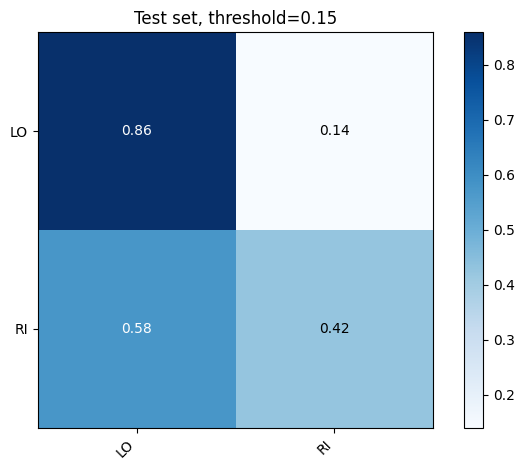

Train accuracy: 0.9093927335232758


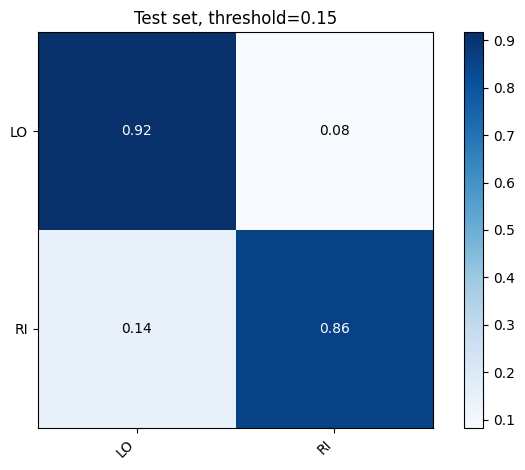

In [30]:
THRESHOLD = 0.15

y_test_pred_nums = [0 if x_ < THRESHOLD else 1 for x_ in y_test_pred]
y_train_pred_nums = [0 if x_ < THRESHOLD else 1 for x_ in y_train_pred]

print("Test accuracy:", calculate_accuracy(y_test_nums, y_test_pred_nums))
plot_confusion_matrix(y_test_nums, y_test_pred_nums, classes=[0, 1], class_labels=["LO", "RI"], normalize=True,
                      title=f"Test set, threshold={THRESHOLD}")

print("Train accuracy:", calculate_accuracy(y_train_nums, y_train_pred_nums))
plot_confusion_matrix(y_train_nums, y_train_pred_nums, classes=[0, 1], class_labels=["LO", "RI"], normalize=True,
                      title=f"Test set, threshold={THRESHOLD}")

Test accuracy: 0.8535545023696682


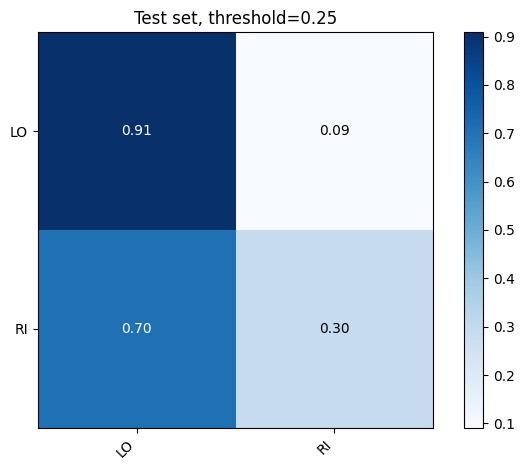

Train accuracy: 0.9328686806847347


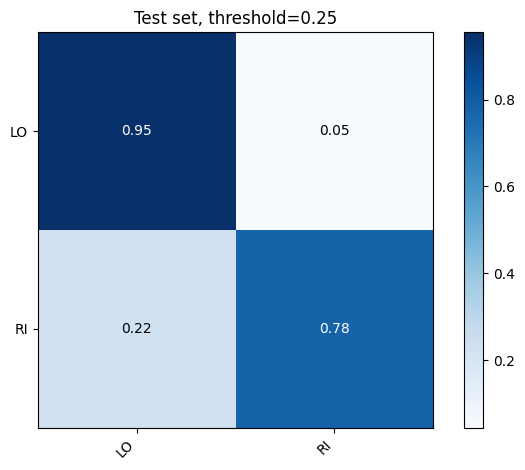

In [31]:
THRESHOLD = 0.25

y_test_pred_nums = [0 if x_ < THRESHOLD else 1 for x_ in y_test_pred]
y_train_pred_nums = [0 if x_ < THRESHOLD else 1 for x_ in y_train_pred]

print("Test accuracy:", calculate_accuracy(y_test_nums, y_test_pred_nums))
plot_confusion_matrix(y_test_nums, y_test_pred_nums, classes=[0, 1], class_labels=["LO", "RI"], normalize=True,
                      title=f"Test set, threshold={THRESHOLD}")

print("Train accuracy:", calculate_accuracy(y_train_nums, y_train_pred_nums))
plot_confusion_matrix(y_train_nums, y_train_pred_nums, classes=[0, 1], class_labels=["LO", "RI"], normalize=True,
                      title=f"Test set, threshold={THRESHOLD}")

Test accuracy: 0.8734597156398104


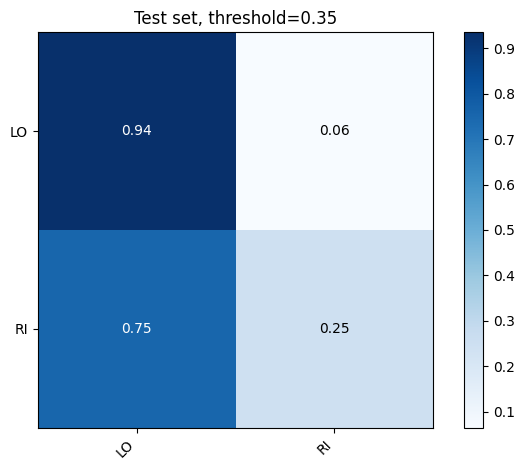

Train accuracy: 0.9396500977183357


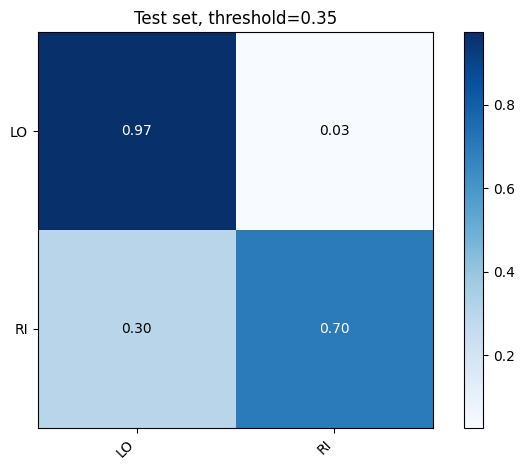

In [32]:
THRESHOLD = 0.35

y_test_pred_nums = [0 if x_ < THRESHOLD else 1 for x_ in y_test_pred]
y_train_pred_nums = [0 if x_ < THRESHOLD else 1 for x_ in y_train_pred]

print("Test accuracy:", calculate_accuracy(y_test_nums, y_test_pred_nums))
plot_confusion_matrix(y_test_nums, y_test_pred_nums, classes=[0, 1], class_labels=["LO", "RI"], normalize=True,
                      title=f"Test set, threshold={THRESHOLD}")

print("Train accuracy:", calculate_accuracy(y_train_nums, y_train_pred_nums))
plot_confusion_matrix(y_train_nums, y_train_pred_nums, classes=[0, 1], class_labels=["LO", "RI"], normalize=True,
                      title=f"Test set, threshold={THRESHOLD}")

Test accuracy: 0.888388625592417


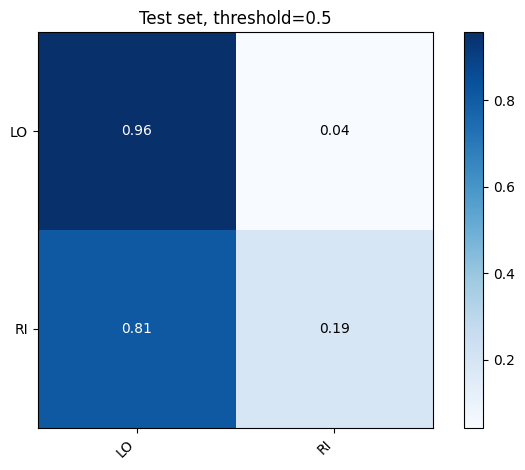

Train accuracy: 0.9396265511314135


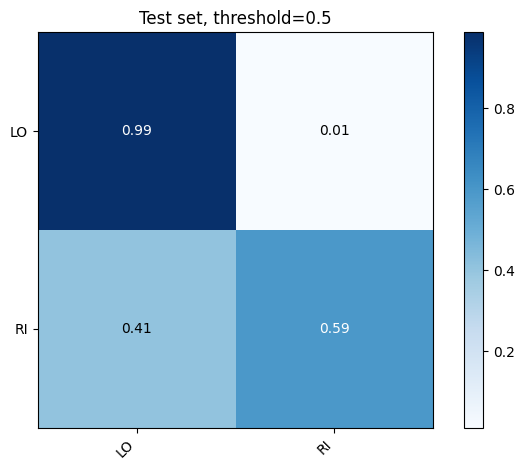

In [33]:
THRESHOLD = 0.5

y_test_pred_nums = [0 if x_ < THRESHOLD else 1 for x_ in y_test_pred]
y_train_pred_nums = [0 if x_ < THRESHOLD else 1 for x_ in y_train_pred]

print("Test accuracy:", calculate_accuracy(y_test_nums, y_test_pred_nums))
plot_confusion_matrix(y_test_nums, y_test_pred_nums, classes=[0, 1], class_labels=["LO", "RI"], normalize=True,
                      title=f"Test set, threshold={THRESHOLD}")

print("Train accuracy:", calculate_accuracy(y_train_nums, y_train_pred_nums))
plot_confusion_matrix(y_train_nums, y_train_pred_nums, classes=[0, 1], class_labels=["LO", "RI"], normalize=True,
                      title=f"Test set, threshold={THRESHOLD}")